<h3> What are Recommendation Systems? </h3>

<h4> Recommender System are the systems that predict the most likely product that the Users are likely to purchase and are interest to.
    
It finds out the match between user and item and inputs the similarities between user and items for recommendations </h4>

<h3> The two most popular ways it can be approached/built are: </h3>

<h3> 1. Collaborative filtering: </h3><h4> The assumption of this approach is that people who have liked an item in the past will also like the same in future. This approach builds a model based on the past behaviour of users. The user behaviour may include previously watched videos, purchased items,given ratings on items. In this way, the model finds an association between the users and the items. The model is then used to predict the item or a rating for the item in which the user may be interested.
Singular value Decomposition is used as a collaborative filtering approach in recommendation systems.
    

<h3> Content- Based Filtering: </h3> <h4>Thia approach is based on a description of the item and a record of the user's preferences. It employs a sequence of discrete, pre-tagged characteristics of an item in order to recommend additional items with similar properties. This approach is best suited when there is sufficient information available on the items but not on the users. Content-based recommender system also include the opinion-based recommender system</h4>

<h3> In this post, we will be focussing on the Collaborative filtering method that is: the user is recommended items that people with similar tastes and preferences liked in the past.

We will be working with MoiveLens Dataset, a movie rating dataset, to develop a recommendation system using the surprise library. Let's get started! </h3>

<h2> Loading Required Libraries </h2>

In [2]:
#! pip install surprise
import os
import pandas as pd
import numpy as np
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import SVD
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from collections import defaultdict




In [3]:
from collections import deque
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected= True)

<h2> THE DATA </h2>

In [7]:
#Loading the data and getting into form
#Load data for all movies

movie_titles = pd.read_csv(r'C:\Users\Lonakshi Bhagat\Desktop\projects\Movie Recommendation System\movie_titles.csv', encoding ='ISO-8859-1',header= None, names= ['Id','Year', 'Name']).set_index('Id')


In [8]:
print('Shape Movie-Titles:/t{}'.format(movie_titles.shape))
movie_titles.sample(5)

Shape Movie-Titles:/t(17770, 2)


,Year,Name
Id,,
1019,2001.0,Diamond Hunters
12515,2000.0,Phish: Bittersweet Motel
11362,2000.0,Kids in the Hall: Same Guys
6438,1951.0,The Man in the White Suit
12966,2004.0,The Aviator


In [9]:
#Load a movie metadata dataset

movie_metadata = pd.read_csv(r"C:\Users\Lonakshi Bhagat\Desktop\projects\Movie Recommendation System\movies_metadata.csv", low_memory = False)[['original_title', 'overview', 'vote_count']].set_index('original_title').dropna()

#Remove the long tail of rarly rated moves
movie_metadata = movie_metadata[movie_metadata['vote_count']>10].drop('vote_count',axis=1)

print('Shape Movie-Metadata:\t{}'.format(movie_metadata.shape))
movie_metadata.sample(5)

Shape Movie-Metadata:	(21604, 1)


,overview
original_title,
Dave,Bill Mitchell is the philandering and distant ...
RoboCop 2,After a successful deployment of the Robocop L...
Repli-Kate,A scientist and his sidekick accidentally clon...
A Life Less Ordinary,"A couple of angels, O'Reilly and Jackson, are ..."
Esteros,Matias and Jeronimo know each other since chil...


In [10]:
#messy mixture of json and csv

#Load single data-file

df_raw = pd.read_csv(r'C:\Users\Lonakshi Bhagat\Desktop\projects\Movie Recommendation System\combined_data_1.txt', header = None, names= ['User','Rating', 'Date'], usecols=[0,1,2])

#Find empty rows to slice dataframe for each movie and reseting the index(User) according to slicing

tmp_movies = df_raw[df_raw['Rating'].isna()]['User'].reset_index()

#Shift the movie_indices by one to get start and endpoints of all movies

movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]
shifted_movie_indices = deque(movie_indices)
shifted_movie_indices.rotate(-1)


In [11]:
#Gather all dataframes
user_data= []

#Iterate over all movies
for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(movie_indices, shifted_movie_indices):
    
    #Check if it is the last movie in file
    if df_id_1 < df_id_2:
        tmp_df = df_raw.loc[df_id_1+1:df_id_2-1].copy()
    else: 
        tmp_df= df_raw.loc[df_id_1+1].copy()
    
    #Create movie_id column
    tmp_df['Movie'] = movie_id
    
    #Appened dataframe to list
    user_data.append(tmp_df)
    
    
#Combine all dataframes
rating = pd.concat(user_data)
del user_data, df_raw, tmp_movies, tmp_df, shifted_movie_indices, movie_indices, df_id_1, movie_id, df_id_2, next_movie_id

print('Shape User-Ratings:\t{}'.format(rating.shape))
rating.sample(5)

Shape User-Ratings:	(24053340, 5)


,0,Date,Movie,Rating,User
8528621,NaN,2005-09-28,1703.0,4.0,2460462
1413366,NaN,2005-02-21,299.0,5.0,1542238
18642009,NaN,2005-01-28,3579.0,4.0,1368192
1971573,NaN,2004-11-15,357.0,2.0,1400019
5252606,NaN,2005-09-14,1066.0,3.0,1889803


In [12]:
rating.shape

(24053340, 5)

In [13]:
rating= rating[0:300000]




In [14]:
ratings = rating[['User', 'Movie', 'Rating']]


In [15]:
ratings.columns= ['UserId', 'movieId', 'rating']

In [16]:
ratings

,UserId,movieId,rating
1,1488844,1.0,3.0
2,822109,1.0,5.0
3,885013,1.0,4.0
4,30878,1.0,4.0
5,823519,1.0,3.0
...,...,...,...
300072,1298406,77.0,3.0
300073,972399,77.0,2.0
300074,2224485,77.0,1.0
300075,1556164,77.0,5.0


In [17]:
ratings_dict = {'itemID': list(ratings.movieId),
                 'userID': list(ratings.UserId),
                'rating': list(ratings.rating) }

df=pd.DataFrame(ratings_dict)
df.shape

(300000, 3)

In [18]:
df.head()

,itemID,userID,rating
0,1.0,1488844,3.0
1,1.0,822109,5.0
2,1.0,885013,4.0
3,1.0,30878,4.0
4,1.0,823519,3.0


<h4> To load a dataset from the above pandas data frame, we will use the load_from_df() method, we will also need a Reader object, and the rating_scale parameter must be specified. </h4>
    

 <h4>The data frame must have three columns, corresponding to the user ids, the item ids, and the ratings in this order. </h4>

In [19]:
#Define the format
reader= Reader(line_format= 'user item rating timestamp', sep='\t')

reader= Reader(rating_scale= (0.5,5.0))

data= Dataset.load_from_df(ratings[['UserId', 'movieId', 'rating']], reader)


In [20]:
#Split data into 5 folds

#data.split(n_folds=5)

In [21]:
data

In [22]:
ratings.groupby('UserId')['rating'].count().reset_index().sort_values('rating', ascending= False)[:10]

,UserId,rating
127914,305344,75
134221,387418,74
108920,2439493,73
50296,1664010,68
84704,2118461,58
34938,1461435,42
80010,2056022,41
70654,1932594,39
48541,1639792,36
23896,1314869,36


In [23]:
ratings

,UserId,movieId,rating
1,1488844,1.0,3.0
2,822109,1.0,5.0
3,885013,1.0,4.0
4,30878,1.0,4.0
5,823519,1.0,3.0
...,...,...,...
300072,1298406,77.0,3.0
300073,972399,77.0,2.0
300074,2224485,77.0,1.0
300075,1556164,77.0,5.0


In [24]:
ratings.rating[1:10]

2     5.0
3     4.0
4     4.0
5     3.0
6     3.0
7     4.0
8     3.0
9     4.0
10    3.0
Name: rating, dtype: float64

<h4> The data is properly distributed and the big chunk of ratings is between 3 and 5 which means people are not very hard towards rating </h4>

In [25]:
count = ratings['rating'].value_counts() 
print(count)
        

4.0    107800
3.0     83690
5.0     66571
2.0     27938
1.0     14001
Name: rating, dtype: int64


<h2> Surprise- Model Selection </h2>

<h4> Surprise is a Python scikit building and analyzing recommender systems that deal with explicit rating data. Maintained by Nicolas Hug.

http://surpriselib.com/ </h4>

<h4> 
Some understanding on the algorithms before we start applying.

1: Normal Predictor: It predicts a random rating based on the distribution of the training set, which is assumed to be normal. It's a basic algorithm that does not do much work but that is still useful for comparing accuracies.

2: SVD: It got popularized by Simon Funk during the Netflix prize and is a Matrix Factorized algorithm. If baselines are not used, it is equivalent to PMF.

3: NMF: It is based on Non-negative matrix factorization and is similar to SVD.

4: KNN Basic: This is a basic collaborative filtering algorithm method. </h4>



In [26]:
data = Dataset.load_from_df(ratings[['UserId', 'movieId', 'rating']],reader)


benchmark= []
#Iterate over all algorithms

for algorithm in [SVD(n_epochs=1, n_factors=20),]:
    
    #Perform cross validation
    
    results= cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose= False)
    
    #Get results and append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index= ['Algorithm']))
    benchmark.append(tmp)

In [27]:
surprise_results= pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')



In [28]:
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,1.012939,0.516852,1.150547


<h2> Tuning the algorithm parameter with GridSearchCV to find the best parameters for the algorithm </h2>

In [29]:
#Default values for svd(): n_factors -100, n_epochs- 20, lr_all- 0.005, reg_all- 0.02

In [30]:

param_grid = {'n_factors': [25,30,35,40], 'n_epochs': [15,20,25], 'lr_all': [0.001, 0.003, 0.005,0.008], 'reg_all': [0.08, 0.1, 0.15]}

gs = GridSearchCV(SVD, param_grid, measures= ['rmse', 'mae'], cv=3)

gs.fit(data)
algo = gs.best_estimator['rmse']
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])


#Assigning values

t=gs.best_params
factors = t['rmse']['n_factors']
epochs = t['rmse']['n_epochs']
lr_value =t['rmse']['lr_all']
reg_value = t['rmse']['reg_all']

0.9932446156100418
{'n_factors': 25, 'n_epochs': 25, 'lr_all': 0.008, 'reg_all': 0.1}


In [31]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD(n_factors = factors, n_epochs =epochs, lr_all=lr_value, reg_all=reg_value)
predictions= algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.9907


0.9906889787036032

In [32]:
predictions[1:10]

[Prediction(uid='1451703', iid=29.0, r_ui=5.0, est=3.982891905241448, details={'was_impossible': False}),
 Prediction(uid='2469190', iid=67.0, r_ui=3.0, est=2.8667691542787637, details={'was_impossible': False}),
 Prediction(uid='2618503', iid=30.0, r_ui=2.0, est=3.816806877299842, details={'was_impossible': False}),
 Prediction(uid='640062', iid=8.0, r_ui=5.0, est=3.203381479628553, details={'was_impossible': False}),
 Prediction(uid='732590', iid=28.0, r_ui=3.0, est=3.958936095126833, details={'was_impossible': False}),
 Prediction(uid='886864', iid=30.0, r_ui=3.0, est=3.7412019466373194, details={'was_impossible': False}),
 Prediction(uid='1077626', iid=30.0, r_ui=3.0, est=3.816806877299842, details={'was_impossible': False}),
 Prediction(uid='2228938', iid=30.0, r_ui=5.0, est=3.491920732105008, details={'was_impossible': False}),
 Prediction(uid='2068028', iid=28.0, r_ui=4.0, est=3.6256207480241356, details={'was_impossible': False})]

<h3> Lets check how good or bad our predictions are: </h3>

 UID: User-id <br>
 iid: Movieid <br>
 Rui: the rating given by the user  <br>
 est: rating estimated by the model <br> 
 lu: No. of items rated by the user <br>
 UI: number of users that have rated the item <br>
 err: abs difference between predicted rating and the actual rating. <br>
     
     
  def get_Iu(uid): """args: uid: the id of the user returns: the number of items rated by the user""" try return:
    len(trainset.ur[trainset.to_inner_uid(uid)]) 
    except Value Error: #user was not part of trainset return 0. 
    
 def get_Ui(iid): """args:iid: the raw id of the items returns: the number of users that have rated the item.""" try:return
len(trainset.ir[trainset.to_inner_iid(iid)]) except ValueError: return 0 

 df_predictions= pd.DataFrame(predictions, columns= ['uid', 'iid', 'rui', 'est', 'details'])
df_predictions['lu']= df_predictions.uid.apply(get_lu)
df_predictions['Ui']=df_predictions.iid.apply(get_Ui)
df_predictions['err']=abs(df_predictions.est- df_predictions.rui) 
    
    

In [33]:
def get_Iu(uid): 
    try: 
        return len(trainset.ur[trainset.to_inner_uid(uid)]) 
    except ValueError:
        return 0

def get_Ui(iid):
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)]) 
    except ValueError:
        return 0

df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_predictions['Iu'] = df_predictions.uid.apply(get_Iu)
df_predictions['Ui'] = df_predictions.iid.apply(get_Ui) 
df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)

In [34]:
df_predictions.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,2321980,26.0,5.0,3.168779,{'was_impossible': False},1,4373,1.831221
1,1451703,29.0,5.0,3.982892,{'was_impossible': False},2,382,1.017108
2,2469190,67.0,3.0,2.866769,{'was_impossible': False},4,213,0.133231
3,2618503,30.0,2.0,3.816807,{'was_impossible': False},0,88904,1.816807
4,640062,8.0,5.0,3.203381,{'was_impossible': False},0,11149,1.796619


<h4> <b> Lets see the 10 best and worst predictions our model made. </b></h4>

In [35]:
best_predictions = df_predictions.sort_values(by='err')[:10]


In [36]:
worst_predictions= df_predictions.sort_values(by='err')[-10:]

In [37]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
51264,794999,71.0,5.0,5.000000,{'was_impossible': False},14,1179,0.000000
44692,2232338,13.0,5.0,5.000000,{'was_impossible': False},2,95,0.000000
45636,49890,76.0,5.0,5.000000,{'was_impossible': False},11,2196,0.000000
51766,1241893,33.0,5.0,5.000000,{'was_impossible': False},7,5115,0.000000
39697,1737149,76.0,5.0,5.000000,{'was_impossible': False},4,2196,0.000000
46389,1716910,33.0,5.0,5.000000,{'was_impossible': False},5,5115,0.000000
58573,1745577,5.0,5.0,5.000000,{'was_impossible': False},8,869,0.000000
23315,776383,58.0,4.0,3.999972,{'was_impossible': False},5,13021,0.000028
12286,2122285,28.0,4.0,3.999965,{'was_impossible': False},4,29938,0.000035
28658,906307,48.0,4.0,3.999962,{'was_impossible': False},1,2719,0.000038


In [38]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
36555,2578242,33.0,1.0,4.467510,{'was_impossible': False},1,5115,3.467510
64422,952874,33.0,1.0,4.490037,{'was_impossible': False},2,5115,3.490037
54305,1494552,33.0,1.0,4.502451,{'was_impossible': False},3,5115,3.502451
40976,1150705,33.0,1.0,4.506149,{'was_impossible': False},7,5115,3.506149
72938,2618819,33.0,1.0,4.527530,{'was_impossible': False},1,5115,3.527530
65673,1705380,33.0,1.0,4.531679,{'was_impossible': False},2,5115,3.531679
30691,8388,33.0,1.0,4.559041,{'was_impossible': False},2,5115,3.559041
51522,2632722,33.0,1.0,4.578975,{'was_impossible': False},2,5115,3.578975
4405,558243,30.0,1.0,4.583710,{'was_impossible': False},3,88904,3.583710
7110,610024,33.0,1.0,4.623334,{'was_impossible': False},3,5115,3.623334


In [39]:
ratings[0:10]

,UserId,movieId,rating
1,1488844,1.0,3.0
2,822109,1.0,5.0
3,885013,1.0,4.0
4,30878,1.0,4.0
5,823519,1.0,3.0
6,893988,1.0,3.0
7,124105,1.0,4.0
8,1248029,1.0,3.0
9,1842128,1.0,4.0
10,2238063,1.0,3.0


<h5> The worst predictions look pretty surprise. Lets look in more details of item = 33, rated 1, when our SVD algorithm predicts 4.4. </h5>

In [40]:
ratings.loc[ratings['movieId']==33]['rating'].describe()

count    6890.000000
mean        4.168650
std         1.152857
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

In [41]:
def configure_plotly_browser_state():
    import IPython
    display(IPython.core.display.HTML('''
    <script src= "/static/components/requirejs/require.js"></script>
         <script>
           requirejs.config({
           paths: {
            base: '/static/base',
            plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
           },
           });
           </script>
           '''))

In [42]:
#To create interactive plots

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
%matplotlib inline


init_notebook_mode(connected =True)
temp = ratings.loc[ratings['movieId']==33]['rating']
configure_plotly_browser_state()

#Create trace
trace = go.Histogram(x=temp.values, name='Ratings',
                     xbins=dict(start=0,end=5, size=.3))


#Create layout

layout= go.Layout(title= 'Number of rating Movieid 33 has received',
                  
                  xaxis= dict(title='Number of Ratings Per Movie'),
                   
                  yaxis= dict(title='Count'), bargap= 0.2)

#Create plot

fig = go.Figure(data=[trace], layout= layout)
iplot(fig)





In [101]:
#As most of users have given movieid =33 rating 5 that is why our algorithm is showing 4.4 results


<h1> K recommendations </h1>

<h3> Recall and Precision at K </h3>

Recall and precision are the classical evaluation metric and are used to evaluate the binary metric and so we have to convert our rating which is scaled from (1-5) into a binary problem relevant and not relevant items.

<h3> Conversion to binary </h3>

Conversion to binary
To do the translation we have to select an arbitrary value on which we can say any rating above that will be considered relevant. There are many methods on selecting that value but for now, we will select 3.5 as the threshold, which means any true rating above 3.5 will be considered relevant and below will be not relevant.

<h3> Deciding 'k' </h3>

In recommendation systems, we are interested in showing the top N items to users and so the best is to compute precision and recall on top N values instead of calculating on all the items

<h2> Definition of Relevant and Recommended </h2>


Relevant: True Rating > = 2.5

Irrelevant: True Rating < 2.5

Recommended item: Predicted Rating > = 3.5

Not Recommended item: Predicted Rating > = 3.5

<h3>  Definition of Precision and Recall </h3>

Precision: It tries to answer "What proportion of positive identifications was actually correct?" i.e True positive / (True positive+False Positive) in RecSys we can say (# of recommended items @k that are relevant) / (# of recommended items @k)

Recall: It tries to answer "What proportion of actual positives were identified correctly?" i.e True positive / (True Positive+False Negative) in RecSys we can say (# of recommended items @k that are relevant) / (# of relevant items @k)


<h3> While recall expresses the ability to find all relevant instances in a dataset, precision expresses the proportion of the data points our model says was relevant actually were relevant </h3>

In some circumstances, we might know that we need to maximize either recall or precision at the cost of the other metric. For example, in disease screening of patients, we would probably want a recall near 1.0 i.e. we want to find all patients who have the disease.

However, in cases where we want to obtain an optimal blend of precision and recall, we can use F1 score which is the harmonic mean of precision and recall taking both metrics into account while calculating it.

f1 score = 2 (precision recall) / (precision + recall)

In [43]:

#Calculate tp,fp,tn,fn at every threshold level (0.0-5.0)

final= []

for threshold in np.arange(0, 5.5, 0.5):
    tp = 0
    fn=0
    fp=0
    tn=0
    temp =[]
    for uid, _ ,true_r, est, _ in predictions:
        if(true_r >= threshold):
            if(est >=threshold):
                tp=+1
            else:
                fn= fn +1
        else:
            if(est >= threshold):
                fp= fp+1
            else: 
                tn=tn+1
    
       
        if tp == 0:
            precision =0
            recall =0
            f1=0
        else:
            precision = tp/(tp + fp)
            recall = tp/(tp+fn)
            f1= 2*(precision *recall)/(precision+recall)
    
    
    temp= [threshold, tp,fp,tn,fn, precision, recall, f1]
    final.append(temp)
    
results = pd.DataFrame(final)
results.rename(columns={0:'threshold', 1:'tp', 2: 'fp', 3: 'tn', 4:'fn', 5: 'Precision', 6:'Recall', 7:'F1'}, inplace=True)
results

,threshold,tp,fp,tn,fn,Precision,Recall,F1
0,0.0,1,0,0,0,1.000000,1.000000,1.000000
1,0.5,1,0,0,0,1.000000,1.000000,1.000000
2,1.0,1,0,0,21,1.000000,0.045455,0.086957
3,1.5,1,3529,46,13,0.000283,0.071429,0.000564
4,2.0,1,3443,132,96,0.000290,0.010309,0.000565
5,2.5,1,9906,715,325,0.000101,0.003067,0.000195
6,3.0,1,7512,3109,4057,0.000133,0.000246,0.000173
7,3.5,1,19069,12405,6389,0.000052,0.000156,0.000079
8,4.0,1,1707,29767,37543,0.000585,0.000027,0.000051
9,4.5,1,72,58392,16348,0.013699,0.000061,0.000122


In [44]:
def precision_recall_at_k(predictions, k ,threshold):
    
    #First map the predictions to each user
    user_est_true= defaultdict(list)
    for uid, _, true_r, est, _ in predictions: 
        user_est_true[uid].append((est, true_r))
        
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        
        #Sort user ratings by estimated value
        user_ratings.sort(key= lambda x :x[0], reverse = True)
        
        #Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        
        #Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        
        #Number of relevant and recommended items in top k
        
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) 
                              for(est, true_r) in user_ratings[:k])
        
        
        #Precision@K: Proportion of recommended items that are relevant
        
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k!=0 else 1
        
        
        #Recall@K: Proportion of relevant items that are recommended
        
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel!=0 else 1
        
    
    #tp = n_rel_and_rec_k
    #fn =  n_rel - tp
    #fp = n_rec_k - tp
    return precisions, recalls    

        
        
    
        
        
    
    
        

In [47]:
results = []
for i in range(2,11):
    precisions, recalls = precision_recall_at_k(predictions, k=i, threshold =2.5)

    #Precision and recall can then be averaged over all users
    prec = sum(prec for prec in precisions.values())/len(recalls)
    rec = sum(rec for rec in recalls.values())/len(recalls)
    results.append({'K': i, 'Precision' : prec, 'Recall': rec})
    
    
results

[{'K': 2, 'Precision': 0.8721318709026727, 'Recall': 0.9884057386728516},
 {'K': 3, 'Precision': 0.8712572491174998, 'Recall': 0.9950130037060352},
 {'K': 4, 'Precision': 0.8709972264246102, 'Recall': 0.995959390860582},
 {'K': 5, 'Precision': 0.8709436459909237, 'Recall': 0.9961682591043882},
 {'K': 6, 'Precision': 0.8709368171121206, 'Recall': 0.9962182245914282},
 {'K': 7, 'Precision': 0.87094019403021, 'Recall': 0.9962382480714082},
 {'K': 8, 'Precision': 0.8709410382597323, 'Recall': 0.9962485535315528},
 {'K': 9, 'Precision': 0.8709392872651674, 'Recall': 0.9962542626309646},
 {'K': 10, 'Precision': 0.8709377113700589, 'Recall': 0.9962582207358117}]

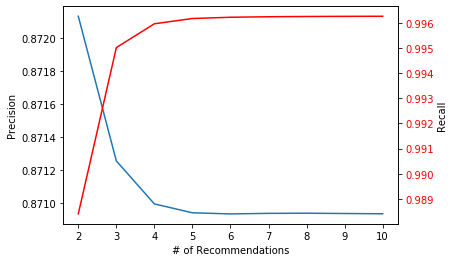

In [50]:
Rec= []
Precision= []
Recall = []

for i in range(0,9):
    Rec.append(results[i]['K'])
    Precision.append(results[i]['Precision'])
    Recall.append(results[i]['Recall'])
    
from matplotlib import pyplot as plt
plt.plot(Rec, Precision)
plt.xlabel('# of Recommendations')
plt.ylabel('Precision')
plt2= plt.twinx()
plt2.plot(Rec, Recall, 'r')
plt.ylabel('Recall')
for tl in plt2.get_yticklabels():
    tl.set_color('r')

As the graph states, Precision drops significantly when K=3

So we will consider the value of K to be 3.

<h2> Time to Recommend movies </h2>

<h3> Now as we know the optimal number of recommendations , its time to give recommendations to users. To do so we have to predict ratings for the movies which user has not yet watched. </h3>

Here we will be using build_anti_tesset() method to get the data for testset as have to predict rating for the (user, item) pairs which are not present

In [51]:
trainset = data.build_full_trainset()  #Build on entire dataset

algo = SVD(n_factors= factors, n_epochs = epochs, lr_all=lr_value, reg_all = reg_value)
algo.fit(trainset)


#Predict ratings for all pairs (u,i) that are NOT in the training set
testset = trainset.build_anti_testset()

#Predicting the ratings for testset
predictions = algo.test(testset)

Below is the function to get all predictions sorted.

In [53]:
def get_all_predictions(predictions):
    
    #First map the predictions to each user
    
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
        
        
    #then sort the predictions for each user
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: [1], reverse= True)
        
    return top_n

In [54]:
all_pred = get_all_predictions(predictions)

In [55]:
all_pred

defaultdict(list,
            {'1488844': [(2.0, 3.4604657360428175),
              (3.0, 3.4936230401874675),
              (4.0, 2.5208150435110004),
              (5.0, 3.6576981657896073),
              (6.0, 3.0349404392457995),
              (7.0, 2.164875888754378),
              (9.0, 2.520320469039037),
              (10.0, 3.0829763381447104),
              (11.0, 3.070185514069319),
              (12.0, 3.3442523740375525),
              (13.0, 4.182275053866699),
              (14.0, 3.0562361942866896),
              (15.0, 3.2723519049734127),
              (16.0, 2.8605236600795783),
              (18.0, 3.4712953245108005),
              (19.0, 3.2682654334928216),
              (20.0, 3.281610858560184),
              (21.0, 3.379812876659272),
              (22.0, 2.253209786175484),
              (23.0, 3.4516064650969014),
              (24.0, 2.975459142588999),
              (25.0, 3.7353522964540034),
              (26.0, 2.6330751649772894),
              (27.0,